# EXPLORATORY DATA ANALYSIS (I.)

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)


In [2]:
predictors = [
    'L3',
    'L2',
    'L1',
    'CF_CL',
    'CASH_TA',
    'SAL_TA',
    'TL_SAL',
    'INV_COST',
    'INV_SAL',
    'CC_SAL',
    'TA_SAL',
    'TL_TA',
    'CF_TL',
    'CL_TA',
    'NCL_TA',
    'EQ_TL',
    'EQ_TA',
    'CL_CC',
    'ROE',
    'EAT_TA',
    'ROA_BRUTTO',
    'CF_TA',
    'CF_SAL',
    'ROS',
    'EAT_YIE',
    'ROI',
    'ROA_NETTO',
    'LABOR_PRODUCTIVITY',
    'SOCLIAB_SAL']

print(len(predictors))

29


In [4]:
DISTRESS_CRITERIA_1Y_OFF = [
 'DPHZ_vat_registration_cancelled_1y_off',
 'RUZ_indirect_criterion_1y_off',
 'RU_konkurz_1y_off',
 'RU_ostatne_konania_1y_off',
 'RUZ_cancelled_1y_off']


DISTRESS_CRITERIA_2Y_OFF = [
 'DPHZ_vat_registration_cancelled_2y_off',
 'RUZ_indirect_criterion_2y_off',
 'RU_konkurz_2y_off',
 'RU_ostatne_konania_2y_off',
 'RUZ_cancelled_2y_off']

In [12]:
financial_ratios_table_raw = pd.read_csv('../../DATA/FINAL/training_data.csv')
display(financial_ratios_table_raw.shape[0])

In [5]:
def combined_issue_2y_off(row):
    if row.DPHZ_vat_registration_cancelled_2y_off == 1: return 1
    if row.RUZ_cancelled_2y_off == 1: return 1
    if row.RU_konkurz_2y_off == 1: return 1
    if row.RU_ostatne_konania_2y_off == 1: return 1
    return 0


def combined_issue_1y_off(row):
    if row.DPHZ_vat_registration_cancelled_1y_off == 1: return 1
    if row.RUZ_cancelled_1y_off == 1: return 1
    if row.RU_konkurz_1y_off == 1: return 1
    if row.RU_ostatne_konania_1y_off == 1: return 1
    return 0


financial_ratios_table_raw['direct_criterion_2y_off'] = financial_ratios_table_raw.apply(combined_issue_2y_off, axis = 1)
financial_ratios_table_raw['direct_criterion_1y_off'] = financial_ratios_table_raw.apply(combined_issue_1y_off, axis = 1)

In [7]:
financial_ratios_table_raw.query('period_length == 12 and is_outlier == False')['year'].value_counts()

2021    228941
2020    222994
2019    212053
2018    200862
2017    187263
2016    176749
2015    171918
2014    167507
Name: year, dtype: int64

In [8]:
data_2016 = financial_ratios_table_raw.query('year == 2016 and sal_class in ["2. Malý", "3. Stredný"]')
data_2017 = financial_ratios_table_raw.query('year == 2017 and sal_class in ["2. Malý", "3. Stredný"]')
data_2018 = financial_ratios_table_raw.query('year == 2018 and sal_class in ["2. Malý", "3. Stredný"]')
data_2019 = financial_ratios_table_raw.query('year == 2019 and sal_class in ["2. Malý", "3. Stredný"]')
financial_ratios_table_raw = None

In [9]:
def get_sample_sizes(data, row_label, column_label):
    samples_df = data.groupby([row_label, column_label])['financial_statement_id'].nunique().to_frame('count').reset_index()
    wide_df = pd.pivot_table(samples_df, index = row_label, columns=column_label, fill_value=0)
    return wide_df

In [11]:
display(get_sample_sizes(data_2017, 'sknace_division', 'sal_class'))
display(get_sample_sizes(data_2017, 'sal_class', 'direct_criterion_2y_off'))

count                                     
sal_class       0. <50,000 1. Mikro 2. Malý 3. Stredný 4. Veľký
sknace_division                                                
A                     2251     1771     191         20        0
B                       81       80      21          6        1
C                    10235     8150    1286        502      166
D                      133      312      84         31       19
E                      467      486      70         17        3
F                     9555     7928     593         89       10
G                    22688    19630    2189        578      136
H                     3880     4031     499        120       20
I                     4346     3300     122          8        0
J                     7330     3915     249         56       12
K                      403      240      31         18        3
L                     8319     4222     290         59        3
M                    23541    11568     535         85        9
N                    13493     6573     416         67        8
O                        1        8       3          0        0
P                     2120      700      19          0        0
Q                     1543     5091      80         38        4
R                     1864      829      54         23        6
S                     2156      705      22          3        0

count      
direct_criterion_2y_off       0     1
sal_class                            
0. <50,000               111549  2857
1. Mikro                  78483  1056
2. Malý                    6609   145
3. Stredný                 1682    38
4. Veľký                    391     9

In [41]:
display(get_sample_sizes(data_2018, 'is_outlier', 'sal_class'))
display(get_sample_sizes(data_2018, 'RUZ_indirect_criterion', 'direct_criterion_2y_off'))

count                   
sal_class  1. Mikro 2. Malý 3. Stredný
is_outlier                            
False         82412    7012       1832
True            926      79         21

count     
direct_criterion_2y_off      0    1
RUZ_indirect_criterion             
0.0                      57437  812
1.0                      33200  833

In [11]:
display(get_sample_sizes(data_2018, 'is_outlier', 'sal_class'))
display(get_sample_sizes(data_2018, 'RUZ_indirect_criterion_2y_off', 'direct_criterion_2y_off'))

count                   
sal_class  1. Mikro 2. Malý 3. Stredný
is_outlier                            
False         83663    7045       1837
True            940      80         21

count     
direct_criterion_2y_off            0    1
RUZ_indirect_criterion_2y_off            
0.0                            79950  717
1.0                            12705  214

In [12]:
# financial_ratios_table_raw = financial_ratios_table_raw.query('entity_ico in @master_set')
# financial_ratios_table_raw

In [13]:
SAL_CLASSES = sorted(data_2018['sal_class'].unique())
SKNACE_GROUPS = data_2018['sknace_division'].unique()

In [15]:
from sklearn.impute import SimpleImputer


def fill_missing_values_mean(data):
    # Instantiate SimpleImputer with mean strategy
    imputer = SimpleImputer(strategy='mean')

    # Fit the imputer on the data and transform the data
    imputed_data = imputer.fit_transform(data)

    return imputed_data

financial_ratios_table_2017 = pd.DataFrame()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        # print(f'sales_class: {sal_class}; sknace: {sknace}')
        subset = data_2017.query('sal_class == @sal_class and sknace_division == @sknace')
        if subset.shape[0] < 10:
            continue
        for col in predictors:
            col_mean = subset[col].mean()
            subset[col].fillna(col_mean)

        financial_ratios_table_2017 = pd.concat([financial_ratios_table_2017, subset], axis = 0)

display(financial_ratios_table_2017.shape[0])




financial_ratios_table_2018 = pd.DataFrame()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        # print(f'sales_class: {sal_class}; sknace: {sknace}')
        subset = data_2018.query('sal_class == @sal_class and sknace_division == @sknace')
        if subset.shape[0] < 10:
            continue
        for col in predictors:
            col_mean = subset[col].mean()
            subset[col].fillna(col_mean)

        financial_ratios_table_2018 = pd.concat([financial_ratios_table_2018, subset], axis = 0)

display(financial_ratios_table_2018.shape[0])

87985

93559

In [16]:
group_column = 'sal_class'

display(
    pd.concat(
        [
            
            financial_ratios_table_2017
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('sample_size'),
            
            financial_ratios_table_2017.query('RUZ_indirect_criterion_2y_off == 1')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('indirect_indicator_count'),
            
            financial_ratios_table_2017.query('direct_criterion_2y_off == 1')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('direct_indicator_count'),

            financial_ratios_table_2017.query('is_outlier == False')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('sample_size_clean'),
            
            financial_ratios_table_2017.query('is_outlier == False and RUZ_indirect_criterion_2y_off == 1')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('indirect_indicator_count_clean'),
            
            financial_ratios_table_2017.query('is_outlier == False and direct_criterion_2y_off == 1')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('direct_indicator_count_clean'),

        ], axis = 1
        ).reset_index())

,sal_class,sample_size,indirect_indicator_count,direct_indicator_count,sample_size_clean,indirect_indicator_count_clean,direct_indicator_count_clean
0,1. Mikro,79531,12737,796,78649,12495,729
1,2. Malý,6751,528,107,6675,512,96
2,3. Stredný,1703,92,27,1684,86,20


## Data distribution

In [55]:
# def plot_histograms(df, columns, filter_out_outliers = True):
#     # Plotting the histograms
#     fig, axes = plt.subplots(nrows=int(len(columns) / 3) + 1, ncols=3, figsize=(20, 30))
#     axes = axes.flatten()

#     for i, column in enumerate(columns):
#         ax = axes[i]


#         data = df.query(f'{column} == {column}')[column]
        
#         Q1 = data.quantile(0.25)
#         Q3 = data.quantile(0.75)
        
#         IQR = Q3 - Q1
        
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR

#         if filter_out_outliers:
#             cleaned_data = data[~((data < lower_bound) | (data > upper_bound))]
#         else:
#             cleaned_data = data

#         bin_width = 2 * IQR / (len(cleaned_data) ** (1/3))

#         num_bins = int(np.ceil((np.max(cleaned_data) - np.min(cleaned_data)) / bin_width))

#         sns.histplot(cleaned_data, bins=num_bins, kde=True, color='skyblue', edgecolor='black', ax=ax)
#         # sns.kdeplot(cleaned_data, color='red', ax=ax, linewidth=2)  # Adding KDE plot
#         ax.set_title(column)
#         ax.set_xlabel('Value')
#         ax.set_ylabel('Frequency')

#     # Hide empty subplots
#     for j in range(len(columns), len(axes)):
#         fig.delaxes(axes[j])

#     plt.tight_layout()
#     plt.show()

In [56]:
# # plot_histograms(financial_ratios_table.query('year == 2018'), predictors)
# plot_histograms(financial_ratios_table.query('year == 2018 and is_outlier == 0'), predictors)

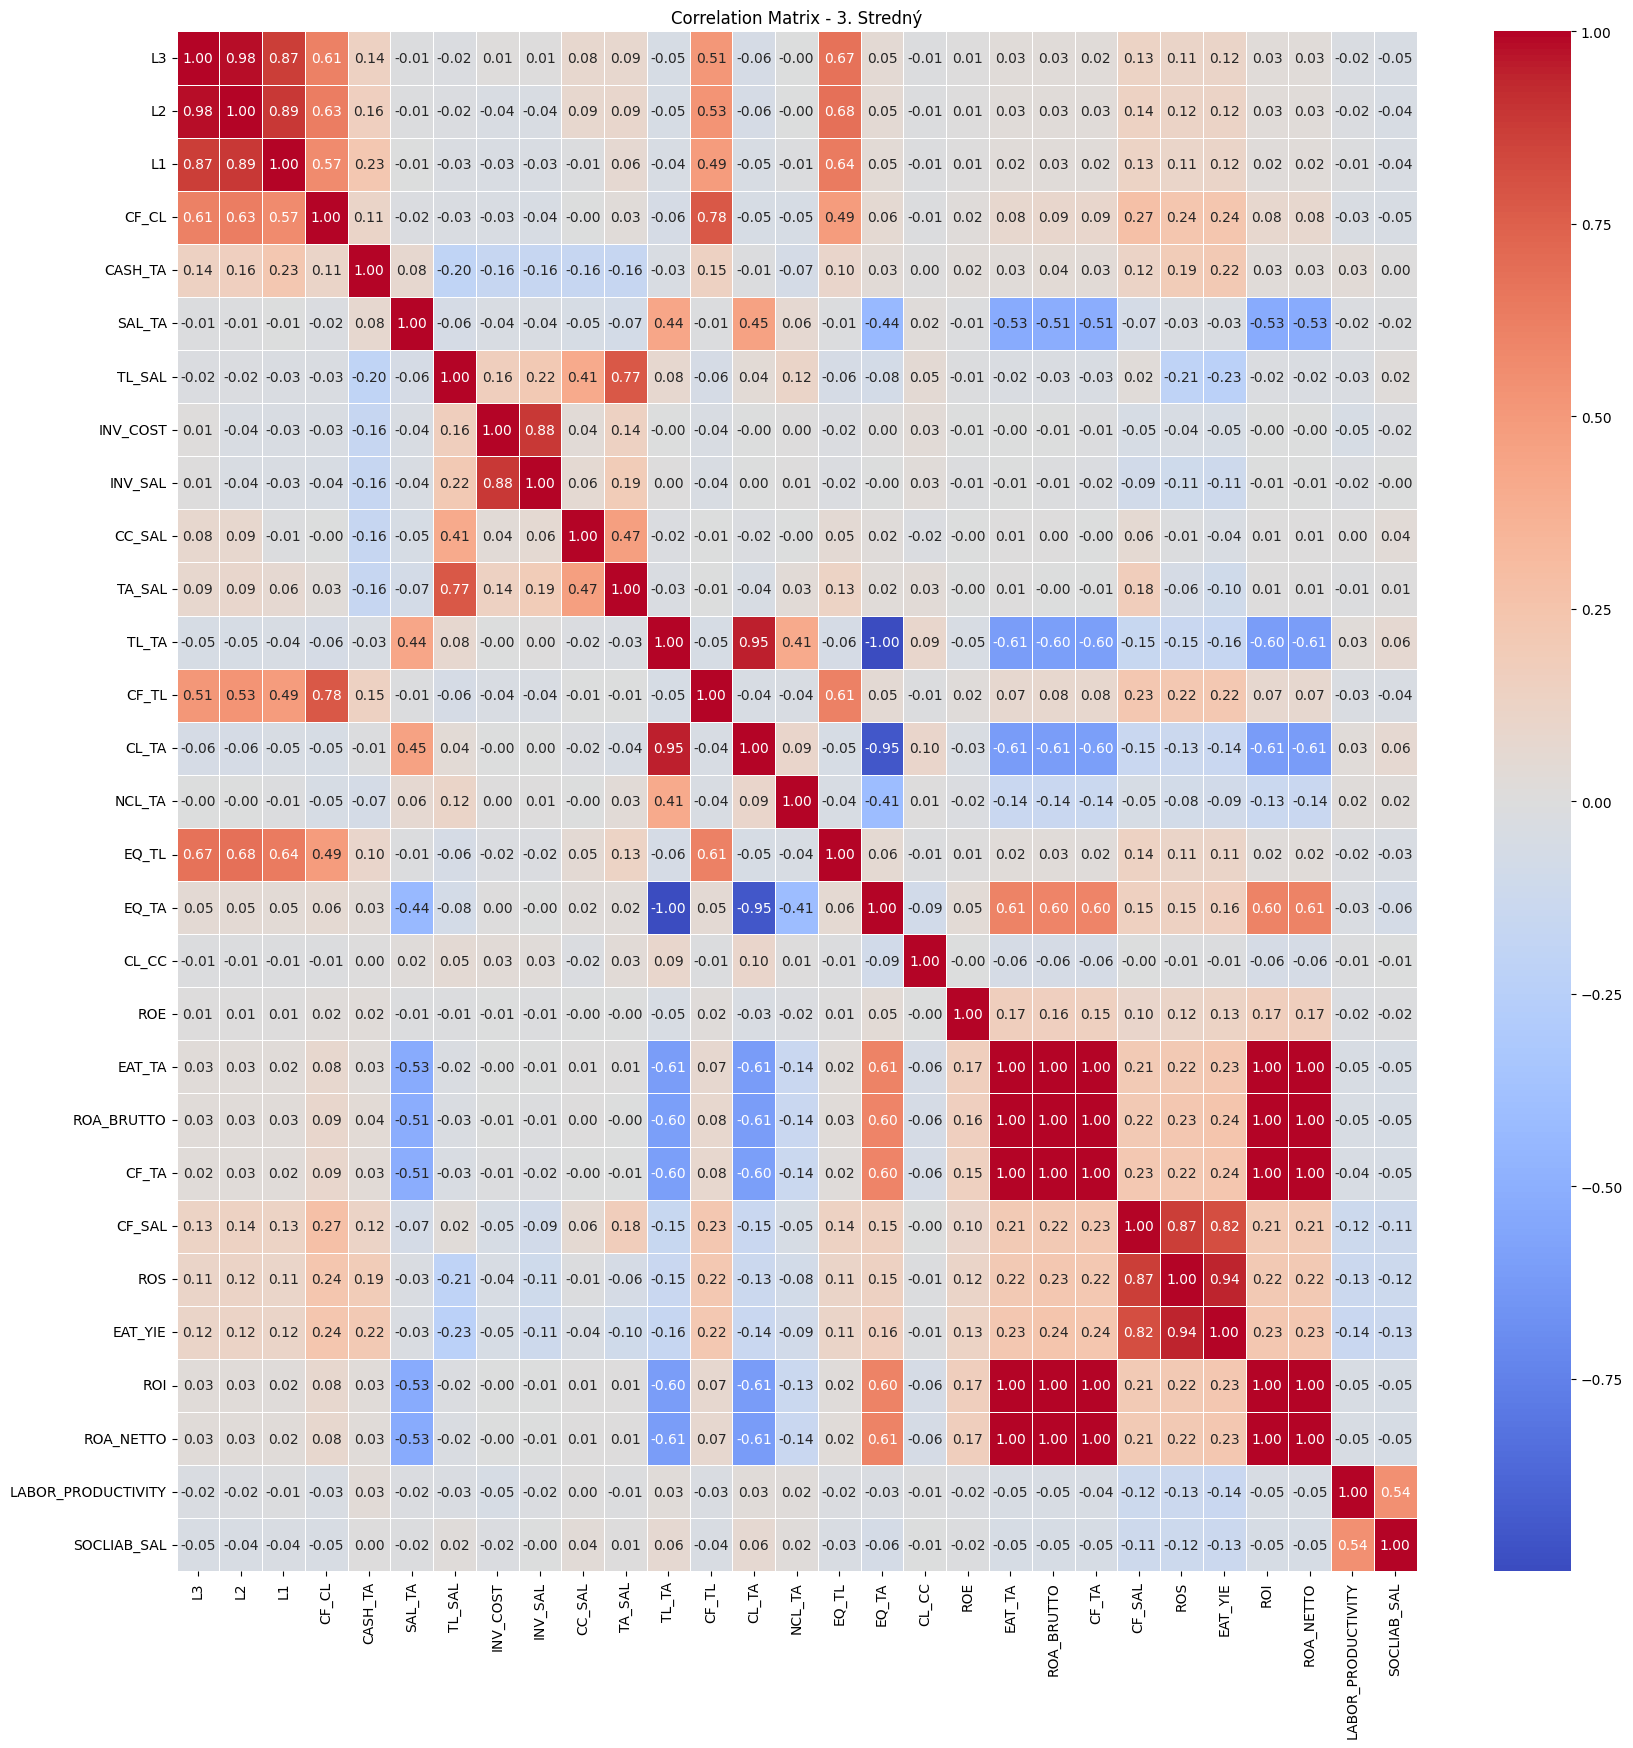

In [17]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = financial_ratios_table_2017.query('is_outlier == False')[predictors].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Correlation Matrix - {sal_class}')
plt.show()

In [18]:
import pandas as pd
import statsmodels.api as sm

def calculate_vif(data):
    # Add a constant term to the independent variables matrix
    X = sm.add_constant(data)

    # Compute VIF for each feature
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [1 / (1 - sm.OLS(X[col], X.drop(columns=[col])).fit().rsquared) for col in X.columns]
    vif_data['VIF'] = vif_data['VIF'].apply(lambda x: round(x, 2))

    return vif_data



vif_result = calculate_vif(pd.DataFrame(fill_missing_values_mean(financial_ratios_table_2017[predictors]), columns=predictors))
display(vif_result)

vif_result = calculate_vif(pd.DataFrame(fill_missing_values_mean(financial_ratios_table_2017[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL', 'LABOR_PRODUCTIVITY', 'SOCLIAB_SAL']]), columns=['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL', 'LABOR_PRODUCTIVITY', 'SOCLIAB_SAL']))
display(vif_result)

C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_40524\1400906885.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  vif_data['VIF'] = [1 / (1 - sm.OLS(X[col], X.drop(columns=[col])).fit().rsquared) for col in X.columns]


,Feature,VIF
0,const,78.95
1,L3,207.21
2,L2,235.65
3,L1,12.49
4,CF_CL,5.73
5,CASH_TA,1.01
6,SAL_TA,5.24
7,TL_SAL,1.63
8,INV_COST,1.16
9,INV_SAL,1.32


,Feature,VIF
0,const,1.92
1,SAL_TA,2.31
2,ROE,1.00
3,ROA_NETTO,1.02
4,TL_TA,3.15
5,CASH_TA,1.00
6,ROS,1.04
7,NCL_TA,1.72
8,TL_SAL,1.03
9,LABOR_PRODUCTIVITY,1.10


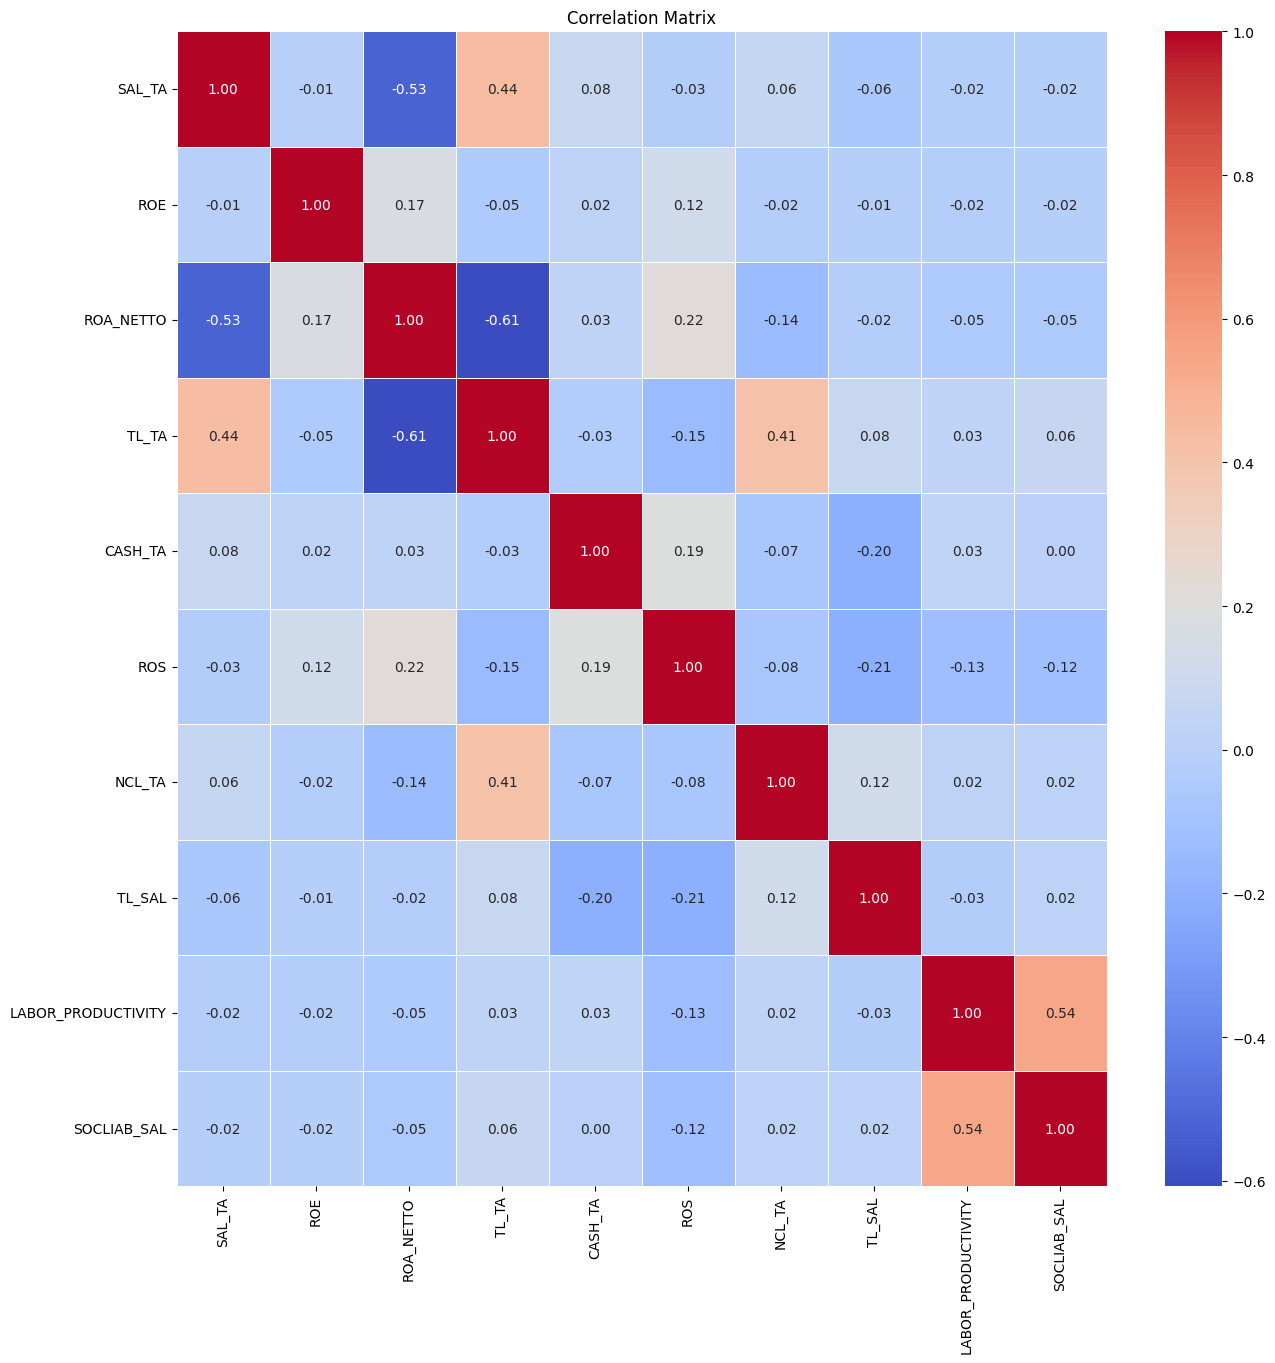

In [19]:
# Calculate the correlation matrix
correlation_matrix = financial_ratios_table_2017.query('is_outlier == False')[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL', 'LABOR_PRODUCTIVITY', 'SOCLIAB_SAL']].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Correlation Matrix')
plt.show()

## Models

### Logistic Regression

Accuracy: 0.829161262429745
Precision: 0.019366876849826277
Recall: 0.34757505773672054
F1 Score: 0.03668941979522184
ROC AUC Score: 0.5906433125766545
Balanced Accuracy: 0.5906433125766545


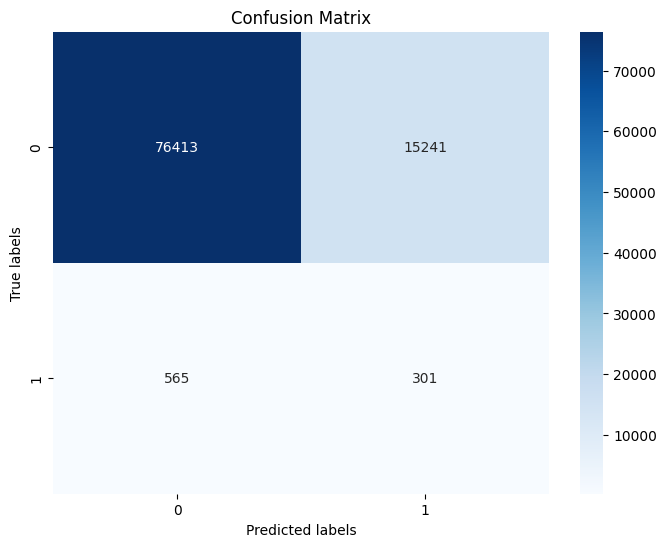

In [22]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Generating some sample data with imbalanced classes

# X =  fill_missing_values_mean(financial_ratios_table_2017.query('is_outlier == False')[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL', 'LABOR_PRODUCTIVITY', 'SOCLIAB_SAL']].values)
# y =  financial_ratios_table_2017.query('is_outlier == False')['direct_criterion_2y_off'].fillna(1).values

# # Splitting the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train =  fill_missing_values_mean(financial_ratios_table_2017.query('is_outlier == False')[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL', 'LABOR_PRODUCTIVITY', 'SOCLIAB_SAL']].values)
y_train =  financial_ratios_table_2017.query('is_outlier == False')['direct_criterion_2y_off'].fillna(1).values

X_test =  fill_missing_values_mean(financial_ratios_table_2018.query('is_outlier == False')[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL', 'LABOR_PRODUCTIVITY', 'SOCLIAB_SAL']].values)
y_test =  financial_ratios_table_2018.query('is_outlier == False')['direct_criterion_2y_off'].fillna(1).values

# Creating SMOTE and RandomUnderSampler objects
smote = SMOTE(sampling_strategy='auto', random_state=42)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Creating logistic regression model
logistic_model = LogisticRegression()

# Creating a pipeline to combine sampling and modeling
pipeline = Pipeline([('SMOTE', smote), ('RUS', rus), ('Logistic Regression', logistic_model)])

# Fitting the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predicting on the testing set
y_pred = pipeline.predict(X_test)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Print all evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Balanced Accuracy:", balanced_accuracy)

# Generating and plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Decision Tree

Accuracy: 0.9159208819714656
Precision: 0.015149389816243513
Recall: 0.12471131639722864
F1 Score: 0.02701688555347092
ROC AUC Score: 0.5240540019697536
Balanced Accuracy: 0.5240540019697536


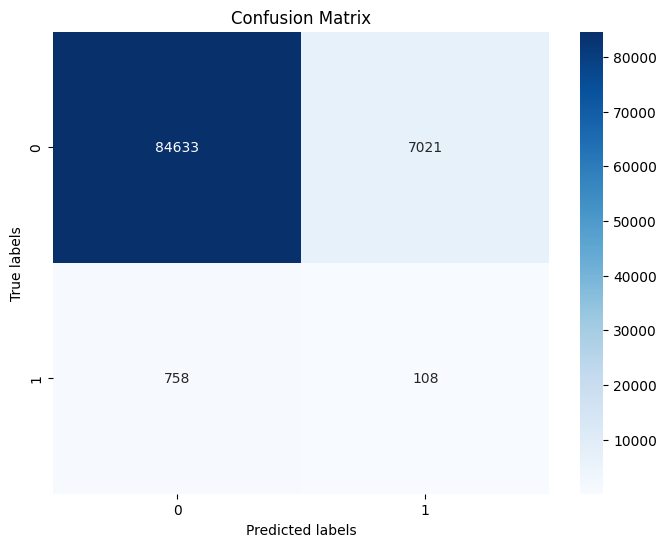

In [23]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


# Creating Decision Tree classifier
tree_model = DecisionTreeClassifier(criterion="gini")

# Creating a pipeline to combine sampling and modeling
pipeline = Pipeline([('SMOTE', smote), ('RUS', rus), ('Decision Tree', tree_model)])

# Fitting the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predicting on the testing set
y_pred = pipeline.predict(X_test)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Print all evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Balanced Accuracy:", balanced_accuracy)

# Generating and plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Support Vector Machine

In [24]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline



# Creating SVM classifier
svm_model = SVC(kernel='linear')  # You can choose different kernels such as 'linear', 'rbf', 'poly', etc.

# Creating a pipeline to combine sampling and modeling
pipeline = Pipeline([('SMOTE', smote), ('RUS', rus), ('SVM', svm_model)])

# Fitting the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predicting on the testing set
y_pred = pipeline.predict(X_test)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Print all evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Balanced Accuracy:", balanced_accuracy)

# Generating and plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


### Neural Net

In [ ]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense


# Reshape y_train to match the expected shape for Keras
y_train = y_train.reshape(-1, 1)


# Creating a neural network classifier
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Creating a pipeline to combine sampling and modeling
pipeline = Pipeline([('SMOTE', smote), ('RUS', rus)])

# Fitting the pipeline on the training data
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Check the shape of X_train_resampled
print("Shape of X_train_resampled:", X_train_resampled.shape)

# Creating a neural network classifier
model = Sequential()
# Adjust the input shape based on the actual number of features in X_train_resampled
model.add(Dense(10, input_dim=X_train_resampled.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the neural network on the resampled data
model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=10, verbose=0)

# Predicting on the testing set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# Print all evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Balanced Accuracy:", balanced_accuracy)

# Generating and plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Shape of X_train_resampled: (97144, 10)
